In [1]:
#imports

import pandas as pd
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split
from numpy import interp
import matplotlib.pyplot as plt
import logging

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json('gutenberg-dataset-v2.json')

In [3]:
earliest_date = df['date'].min()
latest_date = df['date'].max()

df['labels'] = df['date'].apply(lambda date: interp(date, [earliest_date, latest_date], [0, 1]))

# Split data into train and dev subsets
df_small = df.sample(2000, random_state=42)
df_train, df_test = train_test_split(df_small, test_size=0.2, random_state=42, shuffle=True)
df_train

,title,author,date,text_ratio,text,text_len_characters,weights,labels
222955,Gabriel: A Story of the Jews in Prague,S. Kohn,1869,0.961102,you want of me now thee the poor tortured woma...,10889,0.035714,0.520249
139624,"Scientific American, Volume 40, No. 13, March ...",Various,1879,0.941035,with the diameter of the saw t j f asks for th...,10593,0.071429,0.551402
103463,The Romance of Lust: A classic Victorian eroti...,Anonymous,1892,0.971771,but you must be gentle in getting in i said i ...,10762,0.010638,0.591900
206305,The Fiction Factory / Being the experience of ...,William Wallace Cook,1912,0.946508,in the same business are doing and countless o...,11240,0.047619,0.654206
195048,The Merry-go-round,W. Somerset Maugham,1904,0.958170,family fancy your not knowing that cries the o...,10415,0.017544,0.629283
...,...,...,...,...,...,...,...,...
273744,For God and Gold,Julian Stafford Corbett,1887,0.966366,air with fiends as the leaping yelling cimaroo...,10271,0.020000,0.576324
226664,"Traits of American Humour, Vol. 2 of 3",,1852,0.947251,could say the same after spinning a long yarn ...,10819,0.035714,0.467290
211154,"The Catholic World, Vol. 19, April 1874‐Septem...",Various,1874,0.964252,shades and hues too from my lord bishop with h...,11617,0.014493,0.535826
16577,"Three Elephant Power, and Other Stories",A. B. Paterson,1917,0.964638,is that a rider who lost his nerve is afraid o...,10196,0.083333,0.669782


In [4]:
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns.
# If the Dataframe has a header, it should contain a 'text' and a 'labels' column.
# If no header is present, the Dataframe should contain at least two columns,
# with the first column is the text with type str, and the second column in the label with type int.

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.regression = True
model_args.num_train_epochs = 4
#model_args.train_batch_size = 32
model_args.learning_rate = 2e-5

# Create a ClassificationModel
model = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=1,
    args=model_args,
    use_cuda=cuda_available,
)

# Train the model
torch.mps.empty_cache()
model.train_model(df_train)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/1600 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this w

In [5]:
def get_date_from_prediction(prediction):
    return int(interp(prediction, [0, 1], [earliest_date, latest_date]))

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


{'eval_loss': 0.019053966475185008}


  0%|          | 0/400 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Title: Indiana, Date: 1832, Predicted Date: 1905
Title: Whiteladies, Date: 1875, Predicted Date: 1903
Title: The School Queens, Date: 1910, Predicted Date: 1909
Title: Ghosts, Date: 1880, Predicted Date: 1876
Title: The Life of Ludwig van Beethoven, Volume I, Date: 1812, Predicted Date: 1887
Title: My Life as an Author, Date: 1886, Predicted Date: 1880
Title: How music grew, Date: 2023, Predicted Date: 1928
Title: Hyperion, Date: 1882, Predicted Date: 1903
Title: The Squirrel-Cage, Date: 1912, Predicted Date: 1919
Title: The Year When Stardust Fell, Date: 1958, Predicted Date: 1944
Title: Eleanor Ormerod, LL. D., Economic Entomologist : Autobiography and Correspondence, Date: 1904, Predicted Date: 1855
Title: The Seminoles of Florida, Date: 1896, Predicted Date: 1929
Title: Babylon, Volume 3, Date: 1885, Predicted Date: 1880
Title: Captain Jinks, Hero, Date: 1902, Predicted Date: 1917
Title: Naval Actions of the War of 1812, Date: 1812, Predicted Date: 1892
Title: Leaves From the Journ

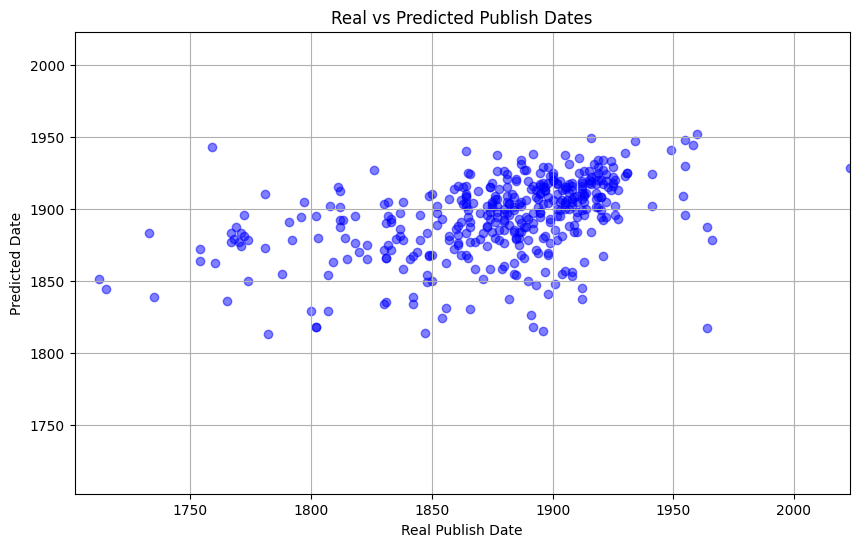

In [6]:
print(result)

predictions, raw_outputs = model.predict(df_test['text'].tolist())
prediction_dates = [get_date_from_prediction(pred) for pred in predictions]

for i in range(len(df_test)):
    print(f"Title: {df_test.iloc[i]['title']}, Date: {df_test.iloc[i]['date']}, Predicted Date: {prediction_dates[i]}")

plt.figure(figsize=(10, 6))
plt.scatter(df_test['date'].tolist(), prediction_dates, color='blue', alpha=0.5)
plt.title('Real vs Predicted Publish Dates')
plt.xlabel('Real Publish Date')
plt.xlim(earliest_date, latest_date)
plt.ylabel('Predicted Date')
plt.ylim(earliest_date, latest_date)
plt.grid(True)
plt.show()